In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
SPY_data = yf.download(tickers = '^GSPC', start = '2020-01-01', interval = '60m')
SPY_data['Adj Close'].isna().sum()

[*********************100%***********************]  1 of 1 completed


0

<AxesSubplot:xlabel='Datetime'>

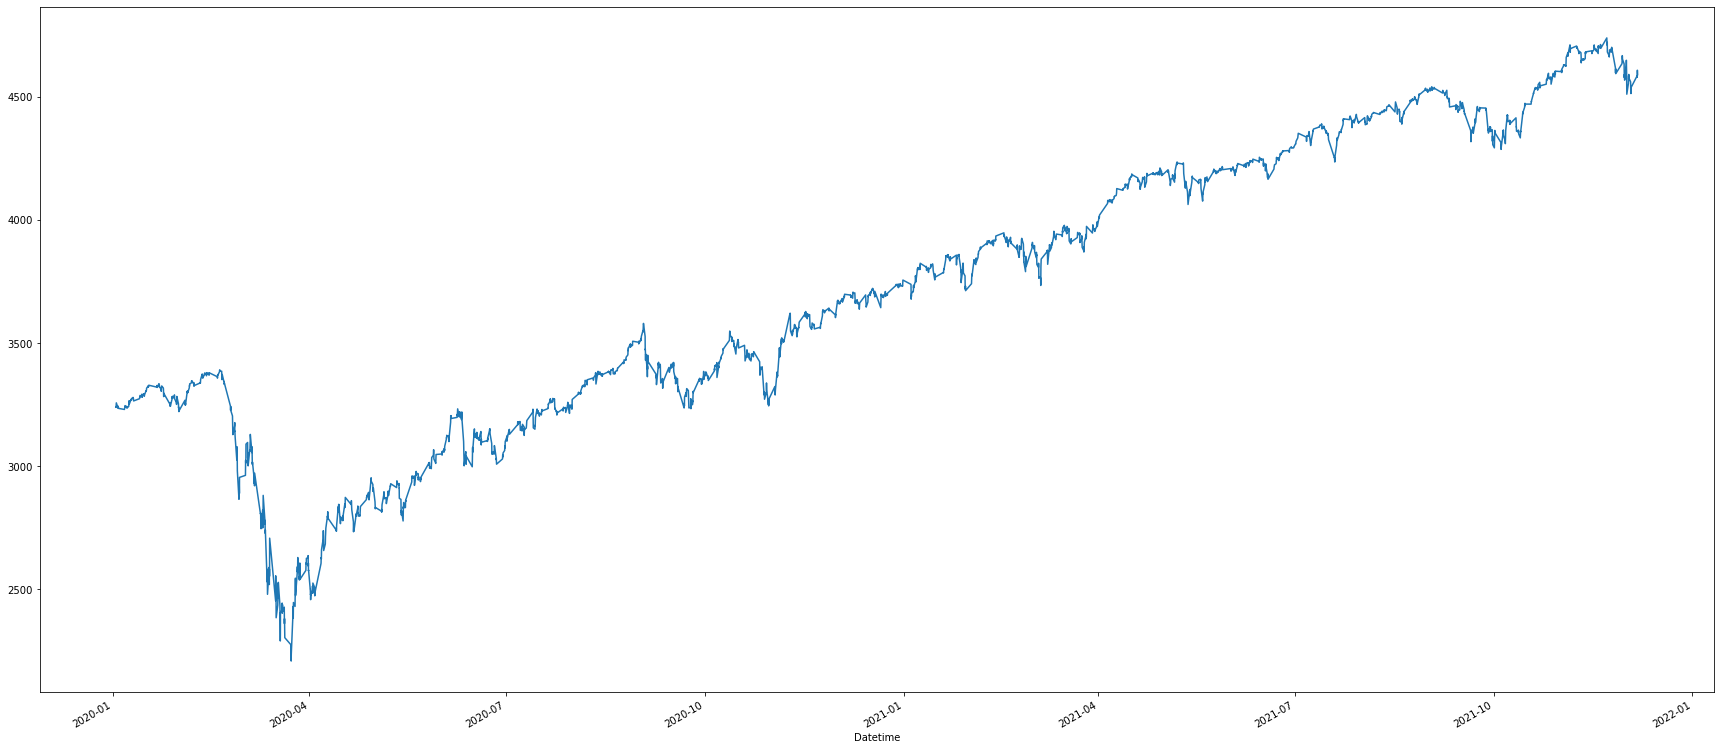

In [37]:
SPY_data['Adj Close'].plot(figsize = (30, 14))

In [3]:
VOO_data = yf.download(tickers = 'VOO', start = '2020-01-01', interval = '60m')
VOO_data['Adj Close'].isna().sum()

[*********************100%***********************]  1 of 1 completed


0

In [4]:
SPLG_data = yf.download(tickers = 'SPLG', start = '2020-01-01', interval = '60m')
SPLG_data['Adj Close'].isna().sum()

[*********************100%***********************]  1 of 1 completed


0

In [7]:
IVV_data = yf.download(tickers = 'IVV', start = '2020-01-01', interval = '60m')
IVV_data['Adj Close'].isna().sum()

[*********************100%***********************]  1 of 1 completed


0

# Simple base model

In [8]:
def checkIncreasing(df, n):
    for i in range(n - 1):
        if df.iloc[i] > df.iloc[i + 1]:
            return False
        
    return True

In [9]:
def checkDecreasing(df, n):
    for i in range(n - 1):
        if df.iloc[i] < df.iloc[i + 1]:
            return False
        
    return True

In [10]:
def checkPositive(df, n):
    positive = df.iloc[0] >= 0
    if positive:
        for i in range(1, n):
            if df[i] < 0:
                return False
    return True

In [11]:
def checkNegative(df, n):
    negative = df.iloc[0] < 0
    if negative:
        for i in range(1, n):
            if df[i] > 0:
                return False
            
    return True

In [45]:
stock_df = pd.DataFrame(columns = ['SPY', 'VOO', 'SPLG', 'IVV'], index = SPY_data['2020-05-01':].index[4:])
totalTransactionCost = 0

In [101]:
def calculate_base_everything(asset_data, column_name, stock_df, past_shift, check_range):
    asset_Moment = (asset_data['Adj Close']['2020-05-01':] - asset_data['Adj Close'].shift(past_shift)).dropna()
    asset_MAVG = asset_data['Adj Close']['2020-05-01':].rolling(past_shift, min_periods = 1).mean().dropna()
    margins = 100000000 / 4
    currAmount = 100000000 / 4
    holdings = 0
    actions = []
    global totalTransactionCost
    for i, date in enumerate(asset_Moment['2020-05-01':].index[check_range:]):
        currAmount = holdings * asset_data['Adj Close'][date] + margins
        act = False
        if holdings == 0:
            if checkIncreasing(asset_MAVG.iloc[i: i + check_range], check_range):
                if checkPositive(asset_Moment[i: i + check_range], check_range):
                    if margins >= currAmount * 0.02:
                        holdings += currAmount * 0.02 / (asset_data['Adj Close'][date] * 1.02)
                        margins -= currAmount * 0.02 * 1.01
                        totalTransactionCost += currAmount * 0.02 * 0.01
                        actions.append(True)
                        act = True
            if checkDecreasing(asset_MAVG.iloc[i: i + check_range], check_range):
                if checkNegative(asset_Moment[i: i + check_range], check_range):
                    holdings -= currAmount * 0.02 / (asset_data['Adj Close'][date] * 0.98)
                    margins += currAmount * 0.02 * 0.99
                    totalTransactionCost += currAmount * 0.02 * 0.01
                    actions.append(True)
                    act = True
        else:
            if holdings < 0:
                if checkIncreasing(asset_MAVG.iloc[i: i + check_range], check_range):
                    if checkPositive(asset_Moment[i: i + check_range], check_range):
                        margins -= holdings * (asset_data['Adj Close'][date] * 1.02) * 1.01
                        holdings = 0
                        totalTransactionCost += currAmount * 0.02 * 0.01
                        actions.append(True)
                        act = True
            elif holdings > 0:
                if checkDecreasing(asset_MAVG.iloc[i: i + check_range], check_range):
                    if checkNegative(asset_Moment[i: i + check_range], check_range):
                        margins += holdings * (asset_data['Adj Close'][date] * 0.98) * 0.99
                        holdings = 0
                        totalTransactionCost += currAmount * 0.02 * 0.01
                        actions.append(True)
                        act = True
        if not act:
            actions.append(act)
        asset_currAmount = holdings * asset_data['Adj Close'][date] + margins
        stock_df.loc[date, column_name] = currAmount
    return actions

In [47]:
stat_df = pd.DataFrame(index = np.arange(1, 20), columns = np.arange(1, 20))
for i in range(1, 20):
    for j in range(1, 20):
        stock_df = pd.DataFrame(columns = ['SPY', 'VOO', 'SPLG', 'IVV'], index = SPY_data['2020-05-01':].index[j:])
        totalTransactionCost = 0
        calculate_base_everything(SPY_data, 'SPY', stock_df, i, j)
        calculate_base_everything(VOO_data, 'VOO', stock_df, i, j)
        calculate_base_everything(SPLG_data, 'SPLG', stock_df, i, j)
        calculate_base_everything(IVV_data, 'IVV', stock_df, i, j)
        net_profit = stock_df.iloc[-1].sum() - 100000000
        net_return = net_profit / 100000000
        stat_df.loc[i, j] = net_profit

KeyboardInterrupt: 

In [313]:
stat_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,81557856.403931,2120344193554426.5,59093198578.709946,1520217669.601561,222861234.606357,64812128.432167,23300420.016254,16228683.115246,11111291.136402,-72589.72591,125940.524605,28476.578208,35715.89539,0.0,0.0,0.0,0.0,0.0,0.0
2,81557856.403931,56103549937648.859375,193727354324.603912,5560241388.126545,706836462.836475,162917420.37372,91103127.645886,41429186.888428,27093950.891633,4313494.137089,5225499.571322,995526.90656,624392.84163,582578.756908,584070.984619,560324.642043,537828.229164,539015.640444,34654.906932
3,81557856.403931,6902873915595.012695,100114883294.138184,9655052238.62562,1697576419.450742,432321236.888451,218701836.506003,111053524.377045,54097767.543176,32284947.511329,16503895.563356,12119389.931419,9048384.723238,4969668.00421,5101441.763223,707383.817366,704828.721554,702588.896706,715696.215019
4,81557856.403931,674363155934.616577,48957690869.410904,13995968515.574387,2854431358.328905,834688123.547109,299682936.859331,187729847.077021,72010151.136039,34169517.441839,29767181.025666,22497209.804269,17744468.6024,13359685.387704,13456974.7983,8745997.572507,6621936.212215,4510557.836946,334314.960379
5,81557856.403931,314704635022.105957,29882305930.785912,8834746752.159254,3758110114.885915,1288722200.713843,614136755.350347,251060941.112979,105137821.56935,49387718.424579,42988998.08354,37110670.403068,32767585.085048,22438104.548208,22758401.884574,22739430.501093,21459552.434767,8452443.855531,8847005.318217
6,81557856.403931,146449966675.88736,19873094565.3764,7125113122.325643,3381568606.855268,2075684263.796276,770356453.902789,292407677.399633,130668624.4226,93637954.677648,71836342.146312,56074926.995867,44193717.453349,33782800.28212,21266197.906209,18006214.788247,13426632.344341,8981669.885151,8908308.885852
7,81557856.403931,93639475513.666702,12490580758.16967,5209005021.862885,2966556746.100496,1498585927.076931,1050916766.917539,340639686.812043,262429898.097026,174161675.842889,108385851.268349,85875627.135595,58821640.775119,42353103.869075,34887897.451333,27559440.136248,22367738.840572,17624794.21972,17730072.099708
8,81557856.403931,53083626139.150436,8643079362.28236,3555060534.181812,2224649371.392803,1203192408.563857,840452746.105034,442814290.851884,307798027.03686,211533595.078847,127285649.868709,92398118.001002,68253664.30995,62377553.427734,42466594.434268,42886534.913302,33208651.091903,32305682.451862,27335024.23102
9,81557856.403931,40782364402.126884,6938744766.887856,2543344162.919222,1601608434.803,974721319.110433,744913700.776625,476297013.196933,358132149.507366,251750336.050943,171016208.114281,126098713.402728,83780645.772545,72012031.934103,63723411.36213,51048155.320214,44083458.300231,27777032.85079,22188646.638204
10,81557856.403931,33838909972.632759,4155735232.046383,2031003747.257796,981477195.811549,674003192.802343,551031792.257601,414618991.455126,303372246.619822,286176051.289451,204716732.088019,159237081.617849,105994241.118896,107162536.543942,71511167.622742,65480902.777795,58690754.216392,41265634.979682,29518225.847278


In [314]:
(stat_df - 100000000) / 100000000

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,-0.184421,21203440.935544,589.931986,14.202177,1.228612,-0.351879,-0.766996,-0.837713,-0.888887,-1.000726,-0.998741,-0.999715,-0.999643,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-0.184421,561034.499376,1936.273543,54.602414,6.068365,0.629174,-0.088969,-0.585708,-0.72906,-0.956865,-0.947745,-0.990045,-0.993756,-0.994174,-0.994159,-0.994397,-0.994622,-0.99461,-0.999653
3,-0.184421,69027.739156,1000.148833,95.550522,15.975764,3.323212,1.187018,0.110535,-0.459022,-0.677151,-0.834961,-0.878806,-0.909516,-0.950303,-0.948986,-0.992926,-0.992952,-0.992974,-0.992843
4,-0.184421,6742.631559,488.576909,138.959685,27.544314,7.346881,1.996829,0.877298,-0.279898,-0.658305,-0.702328,-0.775028,-0.822555,-0.866403,-0.86543,-0.91254,-0.933781,-0.954894,-0.996657
5,-0.184421,3146.04635,297.823059,87.347468,36.581101,11.887222,5.141368,1.510609,0.051378,-0.506123,-0.57011,-0.628893,-0.672324,-0.775619,-0.772416,-0.772606,-0.785404,-0.915476,-0.91153
6,-0.184421,1463.499667,197.730946,70.251131,32.815686,19.756843,6.703565,1.924077,0.306686,-0.06362,-0.281637,-0.439251,-0.558063,-0.662172,-0.787338,-0.819938,-0.865734,-0.910183,-0.910917
7,-0.184421,935.394755,123.905808,51.09005,28.665567,13.985859,9.509168,2.406397,1.624299,0.741617,0.083859,-0.141244,-0.411784,-0.576469,-0.651121,-0.724406,-0.776323,-0.823752,-0.822699
8,-0.184421,529.836261,85.430794,34.550605,21.246494,11.031924,7.404527,3.428143,2.07798,1.115336,0.272856,-0.076019,-0.317463,-0.376224,-0.575334,-0.571135,-0.667913,-0.676943,-0.72665
9,-0.184421,406.823644,68.387448,24.433442,15.016084,8.747213,6.449137,3.76297,2.581321,1.517503,0.710162,0.260987,-0.162194,-0.27988,-0.362766,-0.489518,-0.559165,-0.72223,-0.778114
10,-0.184421,337.3891,40.557352,19.310037,8.814772,5.740032,4.510318,3.14619,2.033722,1.861761,1.047167,0.592371,0.059942,0.071625,-0.284888,-0.345191,-0.413092,-0.587344,-0.704818


In [102]:
stock_df = pd.DataFrame(columns = ['SPY', 'VOO', 'SPLG', 'IVV'], index = SPY_data['2020-05-01':].index[4:])
totalTransactionCost = 0
SPY_actions = calculate_base_everything(SPY_data, 'SPY', stock_df, 4, 4)
VOO_actions = calculate_base_everything(VOO_data, 'VOO', stock_df, 4, 4)
SPLG_actions = calculate_base_everything(SPLG_data, 'SPLG', stock_df, 4, 4)
IVV_actions = calculate_base_everything(IVV_data, 'IVV', stock_df, 4, 4)

In [108]:
from collections import Counter
Counter(SPY_actions) + Counter(VOO_actions) + Counter(SPLG_actions) + Counter(IVV_actions)

Counter({True: 2064, False: 9196})

In [109]:
2064 / (2064 + 9196)

0.18330373001776198

In [104]:
Counter(VOO_actions)

Counter({True: 517, False: 2298})

In [106]:
Counter(SPLG_actions)

Counter({True: 517, False: 2298})

In [107]:
Counter(IVV_actions)

Counter({True: 513, False: 2302})

In [28]:
BTC_data = yf.download(tickers = 'BTC-USD', start = '2020-01-01', interval = '60m')
BTC_data['Adj Close'].isna().sum()

[*********************100%***********************]  1 of 1 completed


0

In [29]:
BTC_data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-01-01 06:00:00+00:00,7216.418457,7226.588867,7215.788086,7220.982910,7220.982910,0
2020-01-01 07:00:00+00:00,7219.592285,7226.676270,7200.886719,7208.649414,7208.649414,0
2020-01-01 08:00:00+00:00,7209.398926,7209.398926,7187.337891,7191.727051,7191.727051,0
2020-01-01 09:00:00+00:00,7192.510742,7203.463867,7192.510742,7196.809570,7196.809570,0
2020-01-01 10:00:00+00:00,7196.520996,7207.301758,7193.462402,7204.458008,7204.458008,0
...,...,...,...,...,...,...
2021-12-07 03:00:00+00:00,50714.011719,51020.339844,50682.335938,51019.109375,51019.109375,278401024
2021-12-07 04:00:00+00:00,51009.191406,51268.429688,50913.195312,50977.242188,50977.242188,481628160
2021-12-07 05:00:00+00:00,50998.078125,51235.894531,50940.250000,50957.433594,50957.433594,390443008


In [32]:
calculate_base_everything(BTC_data['2020-05-01':], 'BTC', stock_df, 4, 4)

In [49]:
display(stock_df)

,SPY,VOO,SPLG,IVV
Datetime,,,,
2020-05-01 13:30:00-04:00,25000000.0,25000000.0,25000000.0,25000000.0
2020-05-01 14:30:00-04:00,24984749.090387,24984772.366031,24984642.268237,24984715.001455
2020-05-01 15:30:00-04:00,24984893.135893,24984752.769048,24984949.627121,24984795.918367
2020-05-04 09:30:00-04:00,24987535.245297,24987462.726078,24987408.439571,24987566.142363
2020-05-04 10:30:00-04:00,24987900.855304,24987729.832349,24987715.798455,24987934.879746
...,...,...,...,...
2021-12-06 11:30:00-05:00,3480383670.15566,3781164413.472753,3339887805.935727,3491147461.718748
2021-12-06 12:30:00-05:00,3626811746.611245,3940283507.814651,3480412503.710989,3638054172.365678
2021-12-06 13:30:00-05:00,3624640190.199362,3937926510.117091,3478351553.561732,3635881346.862708


In [50]:
stock_df['BTC'].dropna().plot(figsize = (60, 14))

KeyError: 'BTC'

In [35]:
stock_df['BTC'].dropna()

Datetime
2020-11-27 13:00:00-05:00    8.389492e+09
2020-12-24 13:00:00-05:00    1.682059e+10
2021-04-19 09:30:00-04:00    2.500000e+07
2021-04-19 11:30:00-04:00    2.500000e+07
2021-04-19 13:30:00-04:00    2.500000e+07
                                 ...     
2021-12-07 03:00:00+00:00    1.462396e+15
2021-12-07 04:00:00+00:00    1.462371e+15
2021-12-07 05:00:00+00:00    1.462360e+15
2021-12-07 06:00:00+00:00    1.462463e+15
2021-12-07 06:26:02+00:00    1.462424e+15
Name: BTC, Length: 13703, dtype: float64

<AxesSubplot:xlabel='Datetime'>

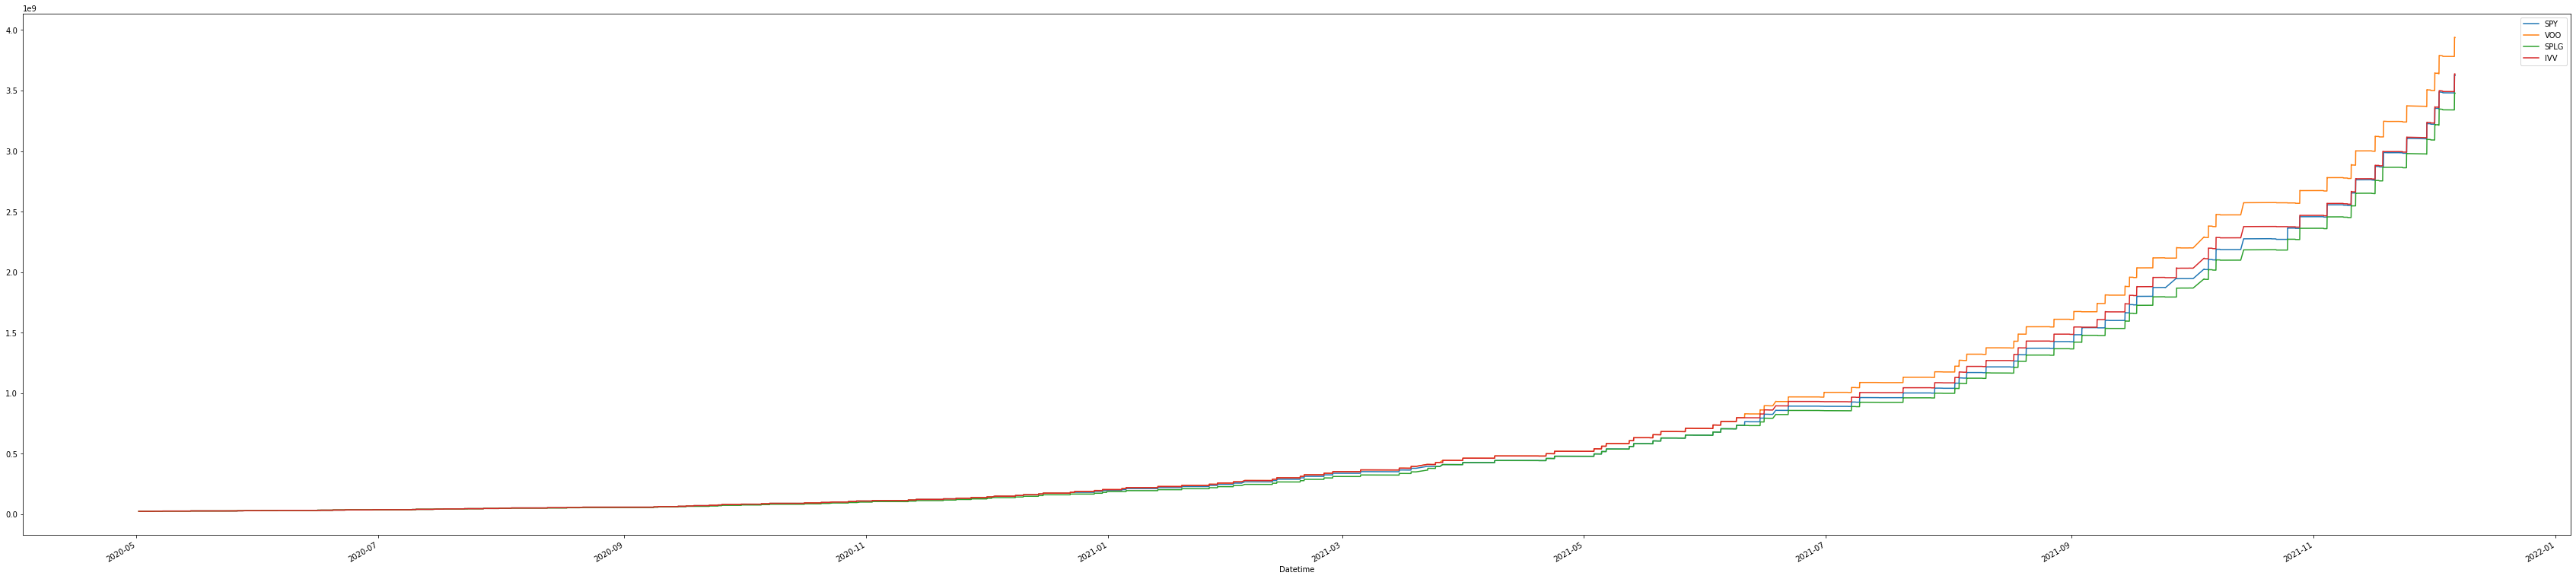

In [51]:
stock_df.plot(figsize = (60, 14))

In [55]:
net_profit = stock_df.iloc[-1].sum() - 100000000
net_return = net_profit / 100000000
net_profit, net_return

(14575863390.72114, 145.7586339072114)

In [110]:
13995909496 / 2064

6780963.903100776

In [56]:
sum_port = stock_df.sum(axis = 1)

In [73]:
sum_port

Datetime
2020-05-01 13:30:00-04:00    1.000000e+08
2020-05-01 14:30:00-04:00    9.993888e+07
2020-05-01 15:30:00-04:00    9.993939e+07
2020-05-04 09:30:00-04:00    9.994997e+07
2020-05-04 10:30:00-04:00    9.995128e+07
                                 ...     
2021-12-06 11:30:00-05:00    1.409258e+10
2021-12-06 12:30:00-05:00    1.468556e+10
2021-12-06 13:30:00-05:00    1.467680e+10
2021-12-06 14:30:00-05:00    1.467603e+10
2021-12-06 15:30:00-05:00    1.467586e+10
Length: 2815, dtype: float64

<AxesSubplot:xlabel='Datetime'>

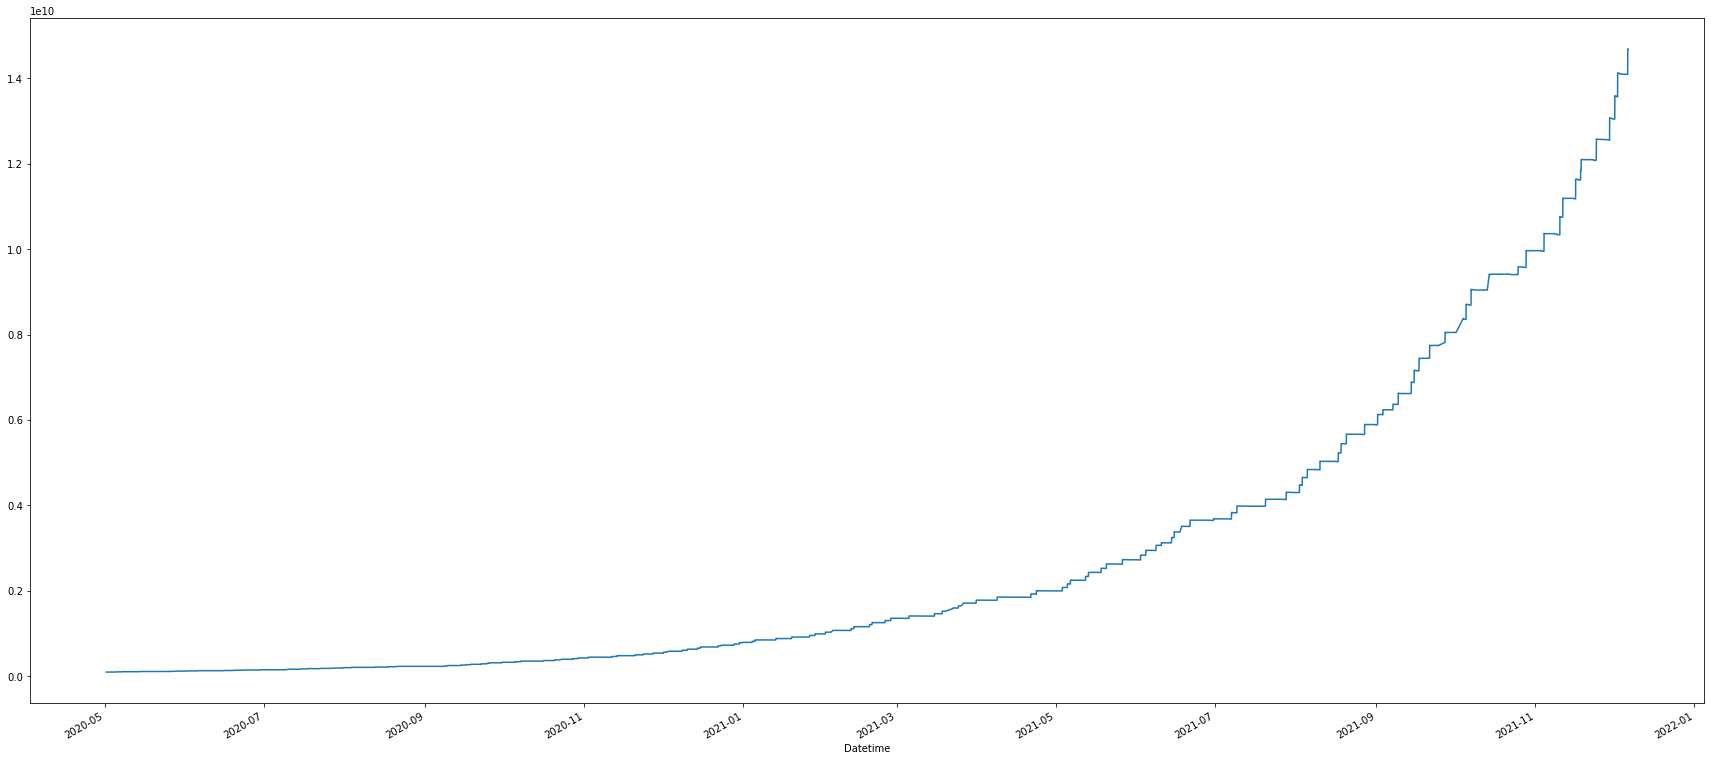

In [82]:
sum_port.plot(figsize = (30, 14))

In [57]:
sum_port.std()

3404844864.7394395

In [58]:
hourly_return = ((sum_port - (sum_port.shift(1))) / sum_port).dropna()
hourly_return

Datetime
2020-05-01 14:30:00-04:00   -0.000612
2020-05-01 15:30:00-04:00    0.000005
2020-05-04 09:30:00-04:00    0.000106
2020-05-04 10:30:00-04:00    0.000013
2020-05-04 11:30:00-04:00   -0.000061
                               ...   
2021-12-06 11:30:00-05:00   -0.000055
2021-12-06 12:30:00-05:00    0.040378
2021-12-06 13:30:00-05:00   -0.000597
2021-12-06 14:30:00-05:00   -0.000053
2021-12-06 15:30:00-05:00   -0.000011
Length: 2814, dtype: float64

In [93]:
VaR = hourly_return.quantile(0.05)
VaR * 252 * 7

-1.0491110681516487

In [90]:
def max_drawdown(df):
    cumpound = (1 + df).cumprod()
    currmax = cumpound.cummax()
    return (cumpound / currmax - 1).min()

In [92]:
max_drawdown(hourly_return) * 252 * 7

-7.665599434017906

In [59]:
hourly_return.std() * np.sqrt(252 * 7)

0.33862323417629825

In [77]:
hourly_return.mean() * 252 * 7 / (hourly_return.std() * np.sqrt(252 * 7))

9.05353460504597

In [60]:
net_profit / sum_port.std()

4.280918505764749

In [61]:
risk_return = (net_return * 4 - 0.012) / (hourly_return.std() * np.sqrt(252 * 7))
risk_return

1721.7440411230175

In [62]:
(net_return - 0.012 / 4) / hourly_return.std() / np.sqrt(63 * 7)

860.8720205615086

In [63]:
vol = hourly_return.std() * np.sqrt(252 * 7)
vol

0.33862323417629825

In [64]:
SPY_hourly = ((SPY_data - SPY_data.shift(1)) / SPY_data).dropna()
SPY_hourly

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-01-02 10:30:00-05:00,-0.002324,-0.002007,0.000056,0.000651,0.000651,1.000000
2020-01-02 11:30:00-05:00,0.000626,-0.000278,-0.000374,-0.000083,-0.000083,-0.221765
2020-01-02 12:30:00-05:00,-0.000099,0.000462,0.001435,-0.000241,-0.000241,-0.155298
2020-01-02 13:30:00-05:00,-0.000222,0.000496,-0.000191,0.001454,0.001454,0.107487
2020-01-02 14:30:00-05:00,0.001442,0.001049,0.001630,0.001022,0.001022,0.172749
...,...,...,...,...,...,...
2021-12-06 11:30:00-05:00,-0.001317,0.000971,0.000872,0.002659,0.002659,-0.388060
2021-12-06 12:30:00-05:00,0.002642,0.003813,0.003079,0.003589,0.003589,-0.097649
2021-12-06 13:30:00-05:00,0.003593,0.000360,0.003572,-0.000336,-0.000336,0.000567


In [65]:
rf = 0.012 / 252 / 7

In [66]:
a = SPY_hourly['Adj Close'][hourly_return.index]

In [67]:
na_indexes = a[pd.isna(a)].index

In [78]:
model = sm.OLS(hourly_return - rf, sm.add_constant(SPY_hourly['Adj Close'][hourly_return.index] - rf)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0006903
Date:                Tue, 07 Dec 2021   Prob (F-statistic):              0.979
Time:                        02:28:26   Log-Likelihood:                 9572.6
No. Observations:                2814   AIC:                        -1.914e+04
Df Residuals:                    2812   BIC:                        -1.913e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000     11.379      0.000       0.001       0.002
Adj Close     -0.0010      0.040     -0.026      0.979      -0.079       0.077
==============================================================================
Omnibus:                     2436.626   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43629.943
Skew:                           4.345   Prob(JB):                         0.00
Kurtosis:                      20.222   Cond. No.                         262.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
0.0017 * 252 * 7

2.9988

In [ ]:
tr = (net_return - 0.012 / 4) / model.params[0]

In [81]:
ir = model.params[0] * np.sqrt(252 * 7) / model.resid.std()
ir

9.018956903835

In [69]:
tr = (net_return - 0.012 / 4) / model.resid.std()
tr

8253.669773952706

In [70]:
stock_df.iloc[-1] / stock_df.iloc[-1].sum()

SPY     0.246962
VOO     0.268311
SPLG    0.236996
IVV     0.247731
Name: 2021-12-06 15:30:00-05:00, dtype: object

In [94]:
totalTransactionCost

297510715.0347485

# ML Models

In [198]:
def compute_WPR(asset_data, lookback):
    highHn = asset_data['High'].rolling(lookback).max()
    lowLn = asset_data['Low'].rolling(lookback).min()
    close = asset_data['Adj Close']
    wpr = -100 * ((highHn - close) / (highHn - lowLn))
    return wpr

In [199]:
def compute_EMA(asset_data, hours, smoothing):
    result = pd.DataFrame(index = asset_data.index[hours:], columns = ['EMA'])
    for i in range(result.shape[0]):
        if i == 0:
            result['EMA'].iloc[i] = asset_data['Adj Close'].iloc[i]
        elif i < hours:
            result['EMA'].iloc[i] = (result['EMA'].iloc[i - 1] * i + asset_data['Adj Close'].iloc[i]) / (i + 1)
        else:
            result['EMA'].iloc[i] = asset_data['Adj Close'].iloc[i] * (1 + smoothing) / (1 + hours) \
                + result['EMA'].iloc[i - 1] * (1 - (smoothing / (1 + hours)))
    return result

In [200]:
def calculate_model_indicators(asset_data, wpr_look_back, hours, smoothing):
    asset_Moment = (asset_data['Adj Close']['2020-05-01':] - asset_data['Adj Close'].shift(6)).dropna()
    asset_MAVG = asset_data['Adj Close']['2020-05-01':].rolling(6, min_periods = 1).mean().dropna()
    asset_WPR = compute_WPR(asset_data['2020-04-28':], wpr_look_back)
    asset_EMA = compute_EMA(asset_data['2020-04-28':], hours, smoothing)
    return asset_Moment, asset_MAVG, asset_WPR, asset_EMA

In [201]:
moment, mavg, wpr, ema = calculate_model_indicators(SPY_data, 15, 21, 3)

In [202]:
SPY_df = pd.concat((moment.rename('moment'), mavg.rename('mavg'), wpr.rename('wpr'), ema), axis = 1).shift(1).dropna()
SPY_df['label'] = None
SPY_df

,moment,mavg,wpr,EMA,label
Datetime,,,,,
2020-05-01 10:30:00-04:00,-59.180176,2855.679932,-92.995818,2893.98999,None
2020-05-01 11:30:00-04:00,-52.780029,2850.329956,-99.918080,2886.599976,None
2020-05-01 12:30:00-04:00,-74.800049,2843.386637,-96.817956,2881.159993,None
2020-05-01 13:30:00-04:00,-76.419922,2839.347473,-95.991223,2880.942505,None
2020-05-01 14:30:00-04:00,-78.850098,2838.053955,-91.542382,2882.247998,None
...,...,...,...,...,...
2021-12-03 11:30:00-05:00,-50.549805,4569.603271,-78.577688,6193.342114,None
2021-12-03 12:30:00-05:00,-43.479980,4562.356608,-84.214564,6182.071829,None
2021-12-03 13:30:00-05:00,-65.100098,4551.506592,-83.611353,6171.405695,None


In [203]:
for date in SPY_df.index:
    SPY_df.loc[date, 'label'] = -1 if SPY_data.loc[date]['Open'] >  SPY_data.loc[date]['Close'] else 1

In [204]:
SPY_df

,moment,mavg,wpr,EMA,label
Datetime,,,,,
2020-05-01 10:30:00-04:00,-59.180176,2855.679932,-92.995818,2893.98999,-1
2020-05-01 11:30:00-04:00,-52.780029,2850.329956,-99.918080,2886.599976,-1
2020-05-01 12:30:00-04:00,-74.800049,2843.386637,-96.817956,2881.159993,-1
2020-05-01 13:30:00-04:00,-76.419922,2839.347473,-95.991223,2880.942505,1
2020-05-01 14:30:00-04:00,-78.850098,2838.053955,-91.542382,2882.247998,1
...,...,...,...,...,...
2021-12-03 11:30:00-05:00,-50.549805,4569.603271,-78.577688,6193.342114,-1
2021-12-03 12:30:00-05:00,-43.479980,4562.356608,-84.214564,6182.071829,-1
2021-12-03 13:30:00-05:00,-65.100098,4551.506592,-83.611353,6171.405695,-1


In [212]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [213]:
X_train, X_test, y_train, y_test = train_test_split(SPY_df.iloc[:, :-1], SPY_df.iloc[:, -1], test_size=0.25, random_state=42)

In [214]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [215]:
for i in range(7, 15):
    for j in range(5, 10):
        rf = RandomForestClassifier(max_depth = i, min_samples_leaf = j)
        rf.fit(X_train, y_train)
        y_test_predict = rf.predict(X_test)
        print(accuracy_score(np.asarray(y_test), y_test_predict), accuracy_score(y_train, np.asarray(rf.predict(X_train))), i)

0.519203413940256 0.6864326375711575 7
0.5334281650071123 0.6864326375711575 7
0.5163584637268848 0.6778937381404174 7
0.5234708392603129 0.6731499051233396 7
0.5248933143669986 0.6574952561669829 7
0.5248933143669986 0.7319734345351043 8
0.5163584637268848 0.7205882352941176 8
0.5106685633001422 0.7125237191650854 8
0.5206258890469416 0.6888045540796964 8
0.5376955903271693 0.7096774193548387 8
0.5177809388335705 0.7741935483870968 9
0.5149359886201992 0.7471537001897534 9
0.5234708392603129 0.7466793168880456 9
0.5064011379800853 0.7324478178368121 9
0.5064011379800853 0.7367172675521821 9
0.5135135135135135 0.7813092979127134 10
0.48933143669985774 0.7817836812144212 10
0.5149359886201992 0.7751423149905123 10
0.5035561877667141 0.7670777988614801 10
0.5049786628733998 0.7675521821631879 10
0.5206258890469416 0.8121442125237192 11
0.5064011379800853 0.821157495256167 11
0.5092460881934566 0.790796963946869 11
0.5177809388335705 0.7784629981024668 11
0.5049786628733998 0.771347248576

In [220]:
dc_tree = RandomForestClassifier(max_depth = 14, min_samples_leaf = 7)
dc_tree.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=7)

In [231]:
predicted = dc_tree.predict(SPY_df.iloc[:, :-1])
currAmount = 25000000
for i in range(predicted.size):
    if predicted[i] == 1:
        shares = currAmount * 0.02 * 0.99 / (SPY_data.loc[SPY_df.index[i]]['Open'] * 1.01)
        currAmount -= currAmount * 0.02 * 0.99
        currAmount += shares * (SPY_data.loc[SPY_df.index[i]]['Close'] * 0.99) * 0.99
    else:
        shares = currAmount * 0.02 * 0.99 / (SPY_data.loc[SPY_df.index[i]]['Open'] * 0.99)
        currAmount += currAmount * 0.02 * 0.99
        currAmount -= shares * (SPY_data.loc[SPY_df.index[i]]['Close'] * 1.01) * 1.01

In [232]:
currAmount

5000822.004423508

In [216]:
neural_clf = MLPClassifier(hidden_layer_sizes = (145,), activation = 'tanh', alpha = 0.002)
neural_clf.fit(X_train, y_train)
y_test_predict = neural_clf.predict(X_test)
print(accuracy_score(np.asarray(y_test), y_test_predict), accuracy_score(y_train, np.asarray(neural_clf.predict(X_train))))

0.5320056899004267 0.5327324478178368


In [217]:
svc_clf = LinearSVC(max_iter = 3000, penalty = 'l1', C = 10, dual = False)
svc_clf.fit(X_train, y_train)
y_test_predict = svc_clf.predict(X_test)
print(accuracy_score(np.asarray(y_test), y_test_predict), accuracy_score(y_train, np.asarray(svc_clf.predict(X_train))))

0.5320056899004267 0.5327324478178368


C:\Users\14264\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [218]:
gaussNB = GaussianNB()
gaussNB.fit(X_train, y_train)
y_test_predict = gaussNB.predict(X_test)
print(accuracy_score(np.asarray(y_test), y_test_predict), accuracy_score(y_train, np.asarray(gaussNB.predict(X_train))))

0.5277382645803699 0.5426944971537002
